# Enhancing Search Engine Relavance using video subtitles (Using Rags)

**Steps**
1. Load a Document
2. Split it into Chunks
3. Create vectors for each chunk and save them in a vector store.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm

## 1. Load a Document

In [3]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import random
import csv

csv.field_size_limit(2**30)  

# Load the data
loader = CSVLoader(file_path='data/subtitles.csv')
documents = loader.load()

# Sample 30% of the data
documents = random.sample(documents, int(0.3 * len(documents)))

In [4]:
print("Type of loaded data:", type(documents))

print("Number of datapoints:", len(documents))

print("Type of each datapoints:", type(documents[0]))

Type of loaded data: <class 'list'>
Number of datapoints: 24749
Type of each datapoints: <class 'langchain_core.documents.base.Document'>


In [5]:
# documents[1]

In [6]:
# print(documents[0].page_content[0:500])

In [7]:
# print(documents[0].metadata)

In [8]:
from langchain_core.documents import Document
import re
from tqdm import tqdm

# Function to extract the relevant metadata from the page_content
def extract_metadata(document, doc_id):
    page_content = document.page_content

    # Function to safely extract matches or return empty string if not found
    def safe_extract(pattern, content):
        match = re.search(pattern, content)
        return match.group(1) if match else ""

    # Extracting each field safely
    name = safe_extract(r'name:\s*(.*)', page_content)
    season = safe_extract(r'season:\s*(.*)', page_content)
    year = safe_extract(r'year:\s*(\d{4})', page_content)
    episode = safe_extract(r'episode:\s*(.*)', page_content)

    # Extract the subtitles (everything else) and clean it
    subtitles = safe_extract(r'subtitles:\s*(.*)', page_content)

    # Creating new metadata dictionary
    metadata = {
        'name': name,
        'season': season,
        'year': year,
        'episode': episode,
    }


    # Creating new document with ID, updated metadata, and page content
    new_document = Document(
        page_content=subtitles.strip(),  # Keeping only the subtitles text in page_content
        metadata=metadata
    )
    
    return new_document

# Process all documents, extract metadata, and assign an id from 0 to len(documents)-1
data = []
for i, doc in enumerate(tqdm(documents, desc="Extracting metadata and assigning IDs")):
    new_doc = extract_metadata(doc, i)
    data.append(new_doc)


Extracting metadata and assigning IDs: 100%|██████████| 24749/24749 [00:00<00:00, 70753.09it/s]


In [11]:
# Checking the result
print(data[100].metadata)
print(data[100].page_content[:500])  # Print first 100 chars of subtitles

{'name': 'northern exposure', 'season': '04', 'year': '1992', 'episode': '06'}
script info title default file scripttype v . wrapstyle playresx playresy scaledborderandshadow yes audio file video file video aspect ratio video zoom video position v style format name fontname fontsize primarycolour secondarycolour outlinecolour backcolour bold italic underline strikeout scalex scaley spacing angle borderstyle outline shadow alignment marginl marginr marginv encoding style dialogue tahoma h fdfdfd h ff h f hc . . style dialogue tahoma h fdfdfd h ff h f hc . . style dialogue t


In [8]:
# data[0]

In [9]:
# print(data[0].page_content[0:500])

In [10]:
# print(data[0].metadata)

In [11]:
# print(data[0].ids)

In [12]:
print('Meta data in first document: ')
print(data[0].metadata)
print()
print('Subtitles in First document: ')
print(data[0].page_content[0:500])

Meta data in first document: 
{'name': 'sexify', 'season': '02', 'year': '2023', 'episode': '04'}

Subtitles in First document: 
we had a meeting yesterday with the people who run sexiguy . you stupid bastard you stole our idea pathetic thief you haven t got any original thought you are disgusting you re disgusting awful and disgusting it wa a very productive talk that we were able to have with them and well we were able to explain our rationale to them . and we also took the chance to hear them out . what did i steal from you you be quiet we re at my place . i ll say what i want be quiet be quiet exhales the craziest thi


## 2. Split it into Chunks

In [13]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
# chunks = text_splitter.split_documents(documents)

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

chunks = []
for doc in tqdm(data, desc=" Splitting data", unit="data"):
    chunks.extend(text_splitter.split_documents([doc]))


Splitting data: 100%|██████████| 24749/24749 [01:14<00:00, 330.18data/s]

In [14]:
print("Number of Documents:", len(documents))
print()
print("Total number of documents inside list:", len(chunks))
print()
print("Type of variable:", type(chunks))
print()
print("Type of each object inside the list:", type(chunks[0]))
print()
print("Total number of documents inside list:", len(chunks))
print()
print("Content of first chunk:")
print(chunks[0])

Number of Documents: 24749

Total number of documents inside list: 2751797

Type of variable: <class 'list'>

Type of each object inside the list: <class 'langchain_core.documents.base.Document'>

Total number of documents inside list: 2751797

Content of first chunk:
page_content='we had a meeting yesterday with the people who run sexiguy . you stupid bastard you stole our idea pathetic thief you haven t got any original thought you are disgusting you re disgusting awful and disgusting it wa a very productive talk that we were able to have with them and well we were able to' metadata={'name': 'sexify', 'season': '02', 'year': '2023', 'episode': '04'}


In [15]:
# chunks[0].page_content

In [16]:
type(chunks[0])

langchain_core.documents.base.Document

In [17]:
# type(chunks)

In [18]:
type(chunks[0].metadata)

dict

In [19]:
len(chunks)

2751797

In [20]:
# chunks[0]

## 3. Create vectors for each chunk and save them in a vector store.

In [3]:
f = open('keys/openai_key.txt')

OPENAI_API_KEY = f.read()

In [4]:
from langchain.vectorstores import Chroma
from sentence_transformers import SentenceTransformer
from langchain.schema import Document
from langchain.embeddings.base import Embeddings

# Define an embedding class to wrap SentenceTransformer
class SentenceTransformerEmbedding(Embeddings):
    def __init__(self, model_name):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        """Generate embeddings for multiple documents."""
        return self.model.encode(texts, convert_to_tensor=False).tolist()

    def embed_query(self, text):
        """Generate an embedding for a single query."""
        return self.model.encode([text], convert_to_tensor=False)[0].tolist()

# Create the embedding function
embedding_function = SentenceTransformerEmbedding('all-MiniLM-L6-v2')

/opt/anaconda3/lib/python3.12/site-packages/opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py:26: RuntimeWarning: The grpc package installed is at version 1.62.2, but the generated code in opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py depends on grpcio>=1.63.2. Please upgrade your grpc module to grpcio>=1.63.2 or downgrade your generated code using grpcio-tools<=1.62.2. This warning will become an error in 1.65.0, scheduled for release on June 25, 2024.
  warnings.warn(


In [5]:
# pip install langchain_chroma

In [6]:
# Initialize ChromaDB with the embedding function
from langchain_chroma import Chroma

db = Chroma(
    collection_name="vector_database",
    embedding_function=embedding_function,
    persist_directory="./chroma_db_"
)

In [24]:
# Define batch size for processing
batch_size = 100  # Adjust based on performance needs

# Ensure chunks is a list of LangChain Document objects
assert isinstance(chunks, list) and all(isinstance(chunk, Document) for chunk in chunks), \
    "Chunks must be a list of LangChain Document objects"

# Adding documents
for i in tqdm(range(0, len(chunks), batch_size), desc="Adding Documents"):
    batch = chunks[i:i + batch_size]
    db.add_documents(batch)

print("Documents successfully added to the collection.")

Adding Documents: 100%|██████████| 27518/27518 [6:00:30<00:00,  1.27it/s]     

Documents successfully added to the collection.


Building an End-to-End RAG Chain
- Step 1: Initialize an embedding_model
- Step 2: Initialize the Chroma DB Connection
- Step 3: Create a Retriever Object
- Step 4: Initialize a Chat Prompt Template
- Step 5: Initialize a Generator (i.e. Chat Model)
- Step 6: Initialize a Output Parser
- Step 7: Define a RAG Chain
- Step 8: Invoke the Chain

# **Retrievers**

## Step 1 - Initialize an embedding_model

In [1]:
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.embeddings.base import Embeddings

# Define an embedding class to wrap SentenceTransformer
class SentenceTransformerEmbedding(Embeddings):
    def __init__(self, model_name):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        """Generate embeddings for multiple documents."""
        return self.model.encode(texts, convert_to_tensor=False).tolist()

    def embed_query(self, text):
        """Generate an embedding for a single query."""
        return self.model.encode([text], convert_to_tensor=False)[0].tolist()

# Create the embedding function
embedding_function = SentenceTransformerEmbedding('all-MiniLM-L6-v2')

## Step 2 - Initialize a ChromaDB Connection

In [4]:
from langchain_chroma import Chroma

# Initialize the database connection
# If database exist, it will connect with the collection_name and persist_directory
# Otherwise a new collection will be created
db = Chroma(collection_name = "vector_database", 
            embedding_function = embedding_function, 
            persist_directory = "./chroma_db_")

In [5]:
db

## Step 3: Create a Retriever Object

In [6]:

# Converting CHROMA db connection to Retriever Object
retriever = db.as_retriever(search_type = "similarity",
                            search_kwargs = {"k": 5})

print(type(retriever))

<class 'langchain_core.vectorstores.base.VectorStoreRetriever'>


## Step 4: Initialize a Chat Prompt Template

In [7]:

from langchain_core.prompts import ChatPromptTemplate

PROMPT_TEMPLATE = """
Answer the question based solely on the following context:
{context}

Based on the given subtitle/dialogues below:
{question}

Provide only the title of the movie.
"""
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)

## Step 5: Initialize a Generator (i.e. Chat Model)

In [9]:
f = open('keys/openai_key.txt')
OPENAI_API_KEY = f.read()

In [10]:
# Import OpenAI ChatModel
from langchain_openai import ChatOpenAI

# Set the OpenAI Key and initialize a ChatModel
chat_model = ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o-mini")

## Step 6: Initialize a Output Parser

In [11]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

## Step 7: Define a RAG Chain

In [12]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
    
rag_chain = {"context": retriever | format_docs, "question": RunnablePassthrough()} | prompt_template | chat_model | parser

## Step 8: Invoke the Chain

In [46]:
query = """Big man in a suit of armor, take that off what are you?, 
genius billionaire playboy philanthropist, 
I know guys with none of that worth 10 of you, I’ve seen the footage the only thing you really fight for is yourself, 
you’re not the guy to make the sacrifice play to lay down on a wire or let the other guy crawl over you! 
I think I would just cut the wire.  
Always a way out, you know you may not be a threat but you stop pretending to be a hero! 
A hero like you, you’re a laboratory experiment rogers everything special about came out of a bottle"""

# transcription = client.audio.transcriptions.create(
#     model="whisper-1", 
#     file=open('data/query.wav', "rb"))

# query = transcription.text

In [47]:
%%time

result = rag_chain.invoke(query)

print(result)

Avengers: Endgame
CPU times: user 26.4 ms, sys: 43.6 ms, total: 70 ms
Wall time: 636 ms


In [26]:
ground_truth_data_long_dialogues = [
    {
        "query": """Big man in a suit of armor, take that off what are you?,
genius billionaire playboy philanthropist,
I know guys with none of that worth 10 of you, I’ve seen the footage the only thing you really fight for is yourself,
you’re not the guy to make the sacrifice play to lay down on a wire or let the other guy crawl over you!
I think I would just cut the wire.
Always a way out, you know you may not be a threat but you stop pretending to be a hero!
A hero like you, you’re a laboratory experiment rogers everything special about came out of a bottle""",
        "expected_title": "The Avengers" # Your example
    },
    {
        "query": """Don't talk like one of them, you're not! Even if you'd like to be. To them, you're just a freak, like me! They need you right now, but when they don't, they'll cast you out, like a leper! See, their morals, their code... it's a bad joke. Dropped at the first sign of trouble. They're only as good as the world allows them to be. I'll show you. When the chips are down, these... these civilized people? They'll eat each other. See, I'm not a monster. I'm just ahead of the curve.""",
        "expected_title": "The Dark Knight"
    },
    {
        "query": """The Matrix is everywhere. It is all around us. Even now, in this very room. You can see it when you look out your window or when you turn on your television. You can feel it when you go to work... when you go to church... when you pay your taxes. It is the world that has been pulled over your eyes to blind you from the truth. That you are a slave, Neo. Like everyone else, you were born into bondage. Born into a prison that you cannot smell or taste or touch. A prison for your mind.""",
        "expected_title": "The Matrix"
    },
    {
        "query": """There's a passage I got memorized. Ezekiel 25:17. 'The path of the righteous man is beset on all sides by the inequities of the selfish and the tyranny of evil men. Blessed is he who, in the name of charity and good will, shepherds the weak through the valley of darkness, for he is truly his brother's keeper and the finder of lost children. And I will strike down upon thee with great vengeance and furious anger those who attempt to poison and destroy My brothers. And you will know My name is the Lord when I lay My vengeance upon thee.'""",
        "expected_title": "Pulp Fiction"
    },
    {
        "query": """You're not your job. You're not how much money you have in the bank. You're not the car you drive. You're not the contents of your wallet. You're not your f*cking khakis. We're the middle children of history, man. No purpose or place. We have no Great War. No Great Depression. Our Great War's a spiritual war... our Great Depression is our lives.""",
        "expected_title": "Fight Club"
    },
    {
        "query": """It's an energy field created by all living things. It surrounds us and penetrates us; it binds the galaxy together. A Jedi can feel the Force flowing through him. It controls your actions, but it also obeys your commands. You will learn to use it, just as your father did.""", # Adapted from Obi-Wan's explanation
        "expected_title": "Star Wars: Episode IV - A New Hope"
    }
]

In [28]:
from tqdm import tqdm 

results = []

for item in tqdm(ground_truth_data_long_dialogues, desc="Evaluating RAG chain"):
    query = item['query']
    expected_title = item['expected_title']

    try:
        predicted_title = rag_chain.invoke(query)
    except Exception as e:
        predicted_title = f"Error: {str(e)}" # Handle potential errors during invocation

    results.append({
        'query': query,
        'expected_title': expected_title,
        'predicted_title': predicted_title
    })

# Convert results to a Pandas DataFrame for easier analysis
results_df = pd.DataFrame(results)

Evaluating RAG chain: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


In [29]:
results_df.head()

,query,expected_title,predicted_title
0,"Big man in a suit of armor, take that off what...",The Avengers,Iron Man 2
1,"Don't talk like one of them, you're not! Even ...",The Dark Knight,The Dark Knight
2,The Matrix is everywhere. It is all around us....,The Matrix,The Matrix
3,There's a passage I got memorized. Ezekiel 25:...,Pulp Fiction,Pulp Fiction
4,You're not your job. You're not how much money...,Fight Club,Fight Club


In [32]:
def normalize_title(title):
    if not isinstance(title, str):
        return "" 
    title = title.lower().strip()
    return title

results_df['normalized_expected_title'] = results_df['expected_title'].apply(normalize_title)
results_df['normalized_predicted_title'] = results_df['predicted_title'].apply(normalize_title)

results_df['is_correct'] = (results_df['normalized_predicted_title'] == results_df['normalized_expected_title'])

results_df[['normalized_expected_title', 'normalized_predicted_title', 'is_correct']].head()

,normalized_expected_title,normalized_predicted_title,is_correct
0,the avengers,iron man 2,False
1,the dark knight,the dark knight,True
2,the matrix,the matrix,True
3,pulp fiction,pulp fiction,True
4,fight club,fight club,True


In [33]:
# Calculate Exact Match Accuracy
correct_predictions = results_df['is_correct'].sum()
total_queries = len(results_df)
accuracy = correct_predictions / total_queries

print(f"\nTotal Queries: {total_queries}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Exact Match Accuracy: {accuracy:.2%}")


Total Queries: 6
Correct Predictions: 5
Exact Match Accuracy: 83.33%


In [40]:
accuracy = results_df['is_correct'].sum() / len(results_df)
print(accuracy*100)

83.33333333333334


Successfully loaded OpenAI API key from 'keys/openai_key.txt'.
Created 50 dummy documents for testing.
Created test set with 50 queries.
Successfully connected to ChromaDB: ./chroma_db_ with collection: vector_database


Testing K values:   4%|▍         | 1/25 [00:35<14:12, 35.53s/it][A

k = 1, Correct Predictions = 1/50, Accuracy (Title Match) = 0.0200



Testing K values:   8%|▊         | 2/25 [00:58<10:50, 28.27s/it][A

k = 2, Correct Predictions = 1/50, Accuracy (Title Match) = 0.0200



Testing K values:  12%|█▏        | 3/25 [01:25<10:07, 27.62s/it][A

k = 3, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  16%|█▌        | 4/25 [01:50<09:18, 26.61s/it][A

k = 4, Correct Predictions = 1/50, Accuracy (Title Match) = 0.0200



Testing K values:  20%|██        | 5/25 [02:13<08:23, 25.17s/it][A

k = 5, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  24%|██▍       | 6/25 [02:35<07:40, 24.26s/it][A

k = 6, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  28%|██▊       | 7/25 [02:58<07:07, 23.76s/it][A

k = 7, Correct Predictions = 1/50, Accuracy (Title Match) = 0.0200



Testing K values:  32%|███▏      | 8/25 [03:23<06:50, 24.16s/it][A

k = 8, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  36%|███▌      | 9/25 [03:49<06:34, 24.63s/it][A

k = 9, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  40%|████      | 10/25 [04:14<06:14, 24.97s/it][A

k = 10, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  44%|████▍     | 11/25 [04:40<05:52, 25.17s/it][A

k = 11, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  48%|████▊     | 12/25 [05:08<05:38, 26.06s/it][A

k = 12, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  52%|█████▏    | 13/25 [05:35<05:15, 26.31s/it][A

k = 13, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  56%|█████▌    | 14/25 [06:06<05:05, 27.80s/it][A

k = 14, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  60%|██████    | 15/25 [06:37<04:46, 28.63s/it][A

k = 15, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  64%|██████▍   | 16/25 [07:04<04:14, 28.23s/it][A

k = 16, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  68%|██████▊   | 17/25 [07:34<03:49, 28.70s/it][A

k = 17, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  72%|███████▏  | 18/25 [08:06<03:28, 29.85s/it][A

k = 18, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  76%|███████▌  | 19/25 [08:33<02:53, 28.86s/it][A

k = 19, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  80%|████████  | 20/25 [09:05<02:28, 29.73s/it][A

k = 20, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  84%|████████▍ | 21/25 [09:31<01:54, 28.70s/it][A

k = 21, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  88%|████████▊ | 22/25 [09:59<01:25, 28.46s/it][A

k = 22, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  92%|█████████▏| 23/25 [10:29<00:57, 28.97s/it][A

k = 23, Correct Predictions = 0/50, Accuracy (Title Match) = 0.0000



Testing K values:  96%|█████████▌| 24/25 [11:01<00:29, 29.71s/it][A

k = 24, Correct Predictions = 1/50, Accuracy (Title Match) = 0.0200



Testing K values: 100%|██████████| 25/25 [11:34<00:00, 27.79s/it][A


k = 25, Correct Predictions = 1/50, Accuracy (Title Match) = 0.0200


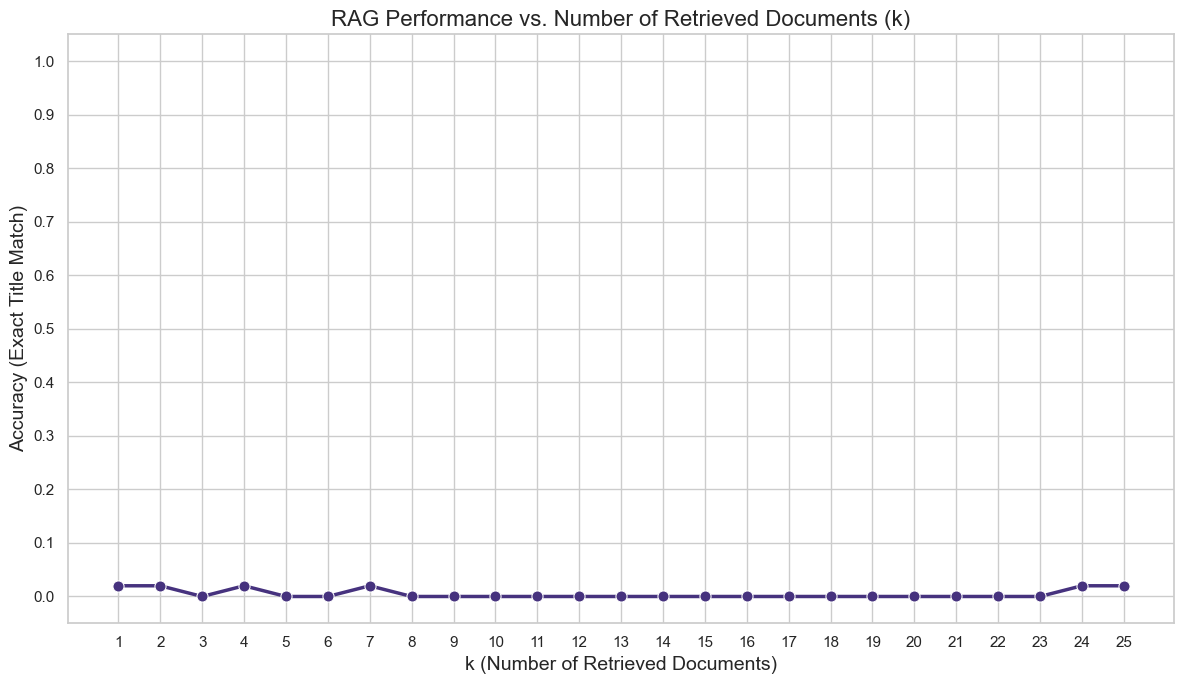


--- Summary of Results (Accuracy per k) ---
k =  1: Accuracy = 0.0200
k =  2: Accuracy = 0.0200
k =  3: Accuracy = 0.0000
k =  4: Accuracy = 0.0200
k =  5: Accuracy = 0.0000
k =  6: Accuracy = 0.0000
k =  7: Accuracy = 0.0200
k =  8: Accuracy = 0.0000
k =  9: Accuracy = 0.0000
k = 10: Accuracy = 0.0000
k = 11: Accuracy = 0.0000
k = 12: Accuracy = 0.0000
k = 13: Accuracy = 0.0000
k = 14: Accuracy = 0.0000
k = 15: Accuracy = 0.0000
k = 16: Accuracy = 0.0000
k = 17: Accuracy = 0.0000
k = 18: Accuracy = 0.0000
k = 19: Accuracy = 0.0000
k = 20: Accuracy = 0.0000
k = 21: Accuracy = 0.0000
k = 22: Accuracy = 0.0000
k = 23: Accuracy = 0.0000
k = 24: Accuracy = 0.0200
k = 25: Accuracy = 0.0200

Best k value based on title accuracy: 1 with accuracy: 0.0200


In [1]:
import random
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns # Import Seaborn
import pandas as pd # Seaborn often works well with pandas DataFrames

# --- Langchain and OpenAI ---
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from sentence_transformers import SentenceTransformer
from langchain.embeddings.base import Embeddings # For custom embedding class

# --- Configuration ---
# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# IMPORTANT: Loading OpenAI API Key from file 'keys/openai_key.txt'
# Make sure this file exists in the same directory as your script,
# or provide the correct path to it.
try:
    # Ensure the path 'keys/openai_key.txt' is correct relative to where your script is executed.
    # For Jupyter notebooks, this is usually the directory where the .ipynb file is located.
    with open('keys/openai_key.txt', 'r') as f: 
        OPENAI_API_KEY = f.read().strip()
    if not OPENAI_API_KEY:
        raise ValueError("API key file 'keys/openai_key.txt' is empty.")
    print("Successfully loaded OpenAI API key from 'keys/openai_key.txt'.")
except FileNotFoundError:
    print("ERROR: API key file 'keys/openai_key.txt' not found.")
    print("Please ensure 'keys/openai_key.txt' exists in the correct directory and contains your API key.")
    OPENAI_API_KEY = "YOUR_OPENAI_API_KEY_PLACEHOLDER" # Fallback - SCRIPT WILL LIKELY FAIL
except Exception as e:
    print(f"Error loading API key from file 'keys/openai_key.txt': {e}")
    OPENAI_API_KEY = "YOUR_OPENAI_API_KEY_PLACEHOLDER" # Fallback - SCRIPT WILL LIKELY FAIL

# The line below is now commented out as we are loading from the file.
# OPENAI_API_KEY = "YOUR_OPENAI_API_KEY" # <<<---!!! THIS LINE IS NOW COMMENTED OUT !!!
# A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A ^ A

CHROMA_DB_PATH = "./chroma_db_"
COLLECTION_NAME = "vector_database"
EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
CHAT_MODEL_NAME = "gpt-3.5-turbo"
NUM_TEST_SAMPLES = 50 # Number of samples to test from your data
K_VALUES_TO_TEST = range(1, 26) # Test k from 1 to 25

# --- Helper Classes and Functions (from your notebook) ---

class SentenceTransformerEmbedding(Embeddings):
    """Wrapper for SentenceTransformer to be used with LangChain."""
    def __init__(self, model_name):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        """Generate embeddings for multiple documents."""
        return self.model.encode(texts, convert_to_tensor=False).tolist()

    def embed_query(self, text):
        """Generate an embedding for a single query."""
        return self.model.encode([text], convert_to_tensor=False)[0].tolist()

def format_docs(docs):
    """Concatenates page_content of multiple documents."""
    return "\n\n".join(doc.page_content for doc in docs)

def parse_predicted_title(predicted_output_str):
    """
    Parses the movie title from the LLM's predicted output string.
    This function assumes the title is on the first line after "1. The title...".
    You might need to make this more robust based on observed LLM outputs.
    """
    lines = predicted_output_str.splitlines()
    for line in lines:
        match = re.search(r"^\s*1\.\s*(?:The title of the movie or web series, or TV show\.|The title of the movie or web series or TV show\.|The title of the movie or web series, or TV show:|The title of the movie or web series or TV show:)?\s*(.*)", line, re.IGNORECASE)
        if match:
            title = match.group(1).strip()
            if title.startswith('"') and title.endswith('"'): # Remove potential quotes
                title = title[1:-1]
            return title.lower() # Lowercase for consistent comparison
    return ""

# --- Main Script ---

if __name__ == '__main__':
    # **Step 1: Load your full dataset ('data' variable from your notebook)**
    # This script expects 'data' to be a list of langchain_core.documents.Document objects.
    # Each Document should have 'page_content' (subtitles) and 'metadata' (name, year, etc.).
    # If running this script as a cell in your Jupyter Notebook, ensure that the cell
    # where 'data' is defined has been executed before this one.

    try:
        # Check if 'data' exists and is a non-empty list of Document objects
        if 'data' in locals() and isinstance(data, list) and data and all(isinstance(d, Document) for d in data):
            print(f"Using 'data' variable found in the current scope (length: {len(data)}).")
        else:
            print("Warning: 'data' variable not found, is empty, or not in the expected format. Using dummy data for demonstration.")
            data = [
                Document(page_content="This is a dialogue from movie one.", metadata={'name': 'Movie One', 'year': '2020'}),
                Document(page_content="Another scene from movie two here.", metadata={'name': 'Movie Two', 'year': '2021'}),
            ]
            while len(data) < NUM_TEST_SAMPLES:
                idx = len(data) + 1
                data.append(Document(page_content=f"Sample dialogue {idx}.", metadata={'name': f'Sample Movie {idx}', 'year': f'{2000+idx}'}))
            print(f"Created {len(data)} dummy documents for testing.")
    except NameError: 
        print("Error: 'data' variable is not defined. Using dummy data for demonstration.")
        data = [
            Document(page_content="This is a dialogue from movie one.", metadata={'name': 'Movie One', 'year': '2020'}),
            Document(page_content="Another scene from movie two here.", metadata={'name': 'Movie Two', 'year': '2021'}),
        ]
        while len(data) < NUM_TEST_SAMPLES:
            idx = len(data) + 1
            data.append(Document(page_content=f"Sample dialogue {idx}.", metadata={'name': f'Sample Movie {idx}', 'year': f'{2000+idx}'}))
        print(f"Created {len(data)} dummy documents for testing.")

    # **Step 2: Prepare Your Evaluation Dataset (X_test, y_test)**
    if not data: # Should not happen if dummy data creation works, but good to check.
        print("CRITICAL ERROR: 'data' is empty. Cannot proceed with test set creation.")
        exit()
        
    if len(data) < NUM_TEST_SAMPLES:
        print(f"Warning: Not enough documents in 'data' ({len(data)}) to create {NUM_TEST_SAMPLES} unique test samples. Using all available {len(data)} documents.")
        test_samples = data
    else:
        test_samples = random.sample(data, NUM_TEST_SAMPLES)

    X_test_queries = [doc.page_content for doc in test_samples]
    y_test_ground_truth_metadata = [doc.metadata for doc in test_samples]
    
    print(f"Created test set with {len(X_test_queries)} queries.")
    if not X_test_queries:
        print("Error: X_test_queries is empty. Cannot proceed.")
        exit()

    # **Step 3: Set Up RAG Chain Components**
    embedding_function = SentenceTransformerEmbedding(EMBEDDING_MODEL_NAME)
    
    try:
        db = Chroma(
            collection_name=COLLECTION_NAME,
            embedding_function=embedding_function,
            persist_directory=CHROMA_DB_PATH
        )
        print(f"Successfully connected to ChromaDB: {CHROMA_DB_PATH} with collection: {COLLECTION_NAME}")
    except Exception as e:
        print(f"Error connecting to ChromaDB or collection not found: {e}")
        print("Please ensure your ChromaDB is populated (by running the main part of your '.ipynb' notebook first) and the path/collection name are correct.")
        exit()

    PROMPT_TEMPLATE_STR = """
Answer the question based on the following context:
{context}

Based on the given subtitle/dialogues below:
{question}

Provide the following details strictly based on the context and 
show in below format

1. The title of the movie or web series, or TV show.
DONT SHOW THE BELOW LINE IF YOU DIDNT FIND IN THE CONTEXT VERY STRICTLY
2. The year of release. 
SHOW THE 3RD POINT IF ITS A WEBSERIES OR ELSE DONT PRINT THE BELOW LINE VERY STRICTLY
3. the season and episode number. (show this only if its webseries)

Do not include any ID (VERY STRICTLY)
Do not add any extra information.
Do not justify your answers.
DO NOT MENTION Not SPECIFIED
DO NOT MENTION NOT APPLICABLE
DO NOT MENTION NOT FOUND
DO NOT MENTION N/A

Avoid phrases like "according to the context/question" or "mentioned in the context/question."
Simply provide the requested details.
"""
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE_STR)
    
    if "YOUR_OPENAI_API_KEY_PLACEHOLDER" in OPENAI_API_KEY or not OPENAI_API_KEY:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("CRITICAL ERROR: OpenAI API key is NOT SET or is still the PLACEHOLDER.")
        print("This means loading from 'keys/openai_key.txt' likely failed or the file is empty/incorrect.")
        print("Please ensure 'keys/openai_key.txt' exists, contains your valid API key, and is readable by the script.")
        print("Script cannot proceed without a valid API key.")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        exit() 
        
    chat_model = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model=CHAT_MODEL_NAME)
    parser = StrOutputParser()

    # **Step 4 & 5: Loop for Hyperparameter 'k' and Evaluate**
    results_by_k = {} 

    for k_value in tqdm(K_VALUES_TO_TEST, desc="Testing K values"):
        try:
            retriever = db.as_retriever(
                search_type="similarity",
                search_kwargs={"k": k_value}
            )
        except Exception as e:
            print(f"Error initializing retriever for k={k_value}: {e}")
            results_by_k[k_value] = 0.0 
            continue

        rag_chain = (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | prompt_template
            | chat_model
            | parser
        )

        correct_predictions_count = 0
        processed_queries_for_k = 0 
        
        for i in tqdm(range(len(X_test_queries)), desc=f"Evaluating k={k_value}", leave=False):
            query = X_test_queries[i]
            ground_truth_meta = y_test_ground_truth_metadata[i]
            
            true_title = ground_truth_meta.get('name', '').strip().lower()
            if not true_title: 
                continue 
            
            processed_queries_for_k +=1

            try:
                predicted_output_str = rag_chain.invoke(query)
                predicted_title = parse_predicted_title(predicted_output_str)
                
                if predicted_title == true_title:
                    correct_predictions_count += 1
            except Exception as e:
                print(f"Error during RAG chain invocation or parsing for query '{query[:50]}...' with k={k_value}: {e}")
                pass 
        
        if processed_queries_for_k > 0:
            accuracy_for_k = correct_predictions_count / processed_queries_for_k
        else:
            accuracy_for_k = 0.0 
            
        results_by_k[k_value] = accuracy_for_k
        print(f"k = {k_value}, Correct Predictions = {correct_predictions_count}/{processed_queries_for_k}, Accuracy (Title Match) = {accuracy_for_k:.4f}")

    # **Step 6: Plot the Results using Seaborn**
    if results_by_k:
        # Convert results to a Pandas DataFrame for Seaborn
        plot_data = pd.DataFrame(list(results_by_k.items()), columns=['K Value', 'Accuracy'])

        plt.figure(figsize=(12, 7)) # Set the figure size
        sns.set_theme(style="whitegrid", palette="viridis") # Set Seaborn theme and a colorful palette

        # Create the line plot
        lineplot = sns.lineplot(
            x='K Value', 
            y='Accuracy', 
            data=plot_data, 
            marker='o', # Add markers to data points
            linewidth=2.5, # Make line slightly thicker
            markersize=8 # Adjust marker size
        )

        lineplot.set_title('RAG Performance vs. Number of Retrieved Documents (k)', fontsize=16)
        lineplot.set_xlabel('k (Number of Retrieved Documents)', fontsize=14)
        lineplot.set_ylabel('Accuracy (Exact Title Match)', fontsize=14)
        
        # Set x-axis ticks to be exactly the K values tested
        lineplot.set_xticks(plot_data['K Value'].unique()) 
        # Set y-axis ticks from 0 to 1.0 with a step of 0.1
        lineplot.set_yticks([i/10 for i in range(11)]) 
        lineplot.set_ylim(-0.05, 1.05) # Set y-axis limits

        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show() # Display the plot
        
        print("\n--- Summary of Results (Accuracy per k) ---")
        for k_val, acc in results_by_k.items():
            print(f"k = {k_val:2d}: Accuracy = {acc:.4f}")
        
        if plot_data['Accuracy'].max() > 0: # Check if there's any non-zero accuracy
            best_k_row = plot_data.loc[plot_data['Accuracy'].idxmax()]
            best_k = int(best_k_row['K Value'])
            best_accuracy = best_k_row['Accuracy']
            print(f"\nBest k value based on title accuracy: {best_k} with accuracy: {best_accuracy:.4f}")
        else:
            print("\nNo valid results to determine the best k (all accuracies might be zero or an error occurred).")

    else:
        print("No results to plot. This might happen if all k values failed or no test queries were processed.")
